In [1]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from helpers import *
from gaussfit import *

data = dataLoaderDict()

fitTimeserie=[]

for timestamp, dataIt in data.items():
  
    if len(dataIt) == 0 : continue
        
    #print(dataIt.pmt)
    #SEL_EAST=(dataIt.pmt>=0) & (dataIt.pmt<180)
    
    #SEL_WEST=(dataIt.pmt>=180) & (dataIt.pmt<360)
        
    _,_, param, errors  = fitGainsDistribution(dataIt)
    
    
    res = param[2]/param[1]
    errorRes = np.sqrt( (errors[1]/param[1])**2 + (errors[2]/param[2])**2 ) * res
    
    if timestamp>=1627584480:    
        fitTimeserie.append( [ timestamp, param[1]+0.11*param[1], param[2]+0.11*param[2], errors[1], errors[2], res*100, errorRes*100 ] )
    else:
        fitTimeserie.append( [ timestamp, param[1], param[2], errors[1], errors[2], res*100, errorRes*100 ] )
    

    #print( param[1], errors[1], timestamp, datetime.fromtimestamp(timestamp), res*100, errorRes*100 )

fitTimeserie = np.array(fitTimeserie)

Mean: [ 4.29467741e-01 -4.46083294e+02  4.56676855e+02] [1.27042233e-02 2.53699579e+01 4.76291042e+01]
Sigma [5.63964197e-02 5.53341641e-05] [6.45548879e-04 4.11676559e-06]
EQ [8.22766549 0.0182466 ] [0.1027677  0.00065537]


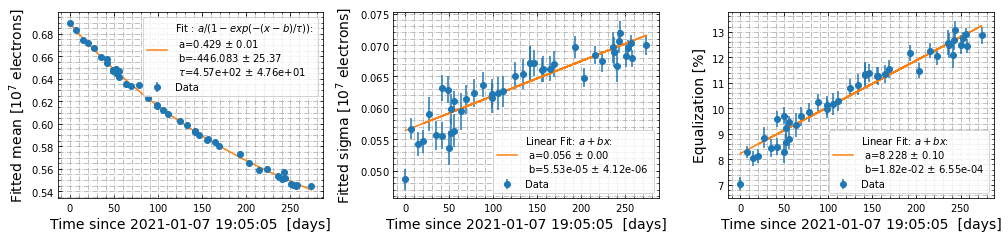

In [2]:
fig, ax = plt.subplots(1,3, figsize=(14, 3.4))

dates = [ datetime.fromtimestamp(t) for t in fitTimeserie[:,0] ]
elapsedTime = [ (t-np.min(fitTimeserie[:,0])) / (3600*24) for t in fitTimeserie[:,0] ] #in days

def decay(x, a, b, tau):
    #return a*np.exp( -x/tau )
    return a/(1-np.exp( -(x-b)/tau ))

def pol(x,a, b):
    return a + x*b


# Central value
params,pcov = curve_fit(decay, elapsedTime[:-1] , fitTimeserie[:-1,1] , p0=[ 0.75, -90, 1200 ] )
perrors = np.diag(pcov)**0.5
print("Mean:", params, perrors )

ys = [ decay( t, *params ) for t in np.sort(elapsedTime) ]

ax[0].errorbar( x=elapsedTime[:], y=fitTimeserie[:,1], yerr=fitTimeserie[:,3], fmt='o', label="Data")
ax[0].plot( np.sort(elapsedTime), ys, '-', label="Fit : $a/(1-exp(-(x-b)/\\tau))$: \n a=%.3f $\pm$ %.2f \n b=%.3f $\pm$ %.2f \n $\\tau$=%.2e $\pm$ %.2e " % (params[0], perrors[0], params[1], perrors[1], params[2], perrors[2] ))

ax[0].set_xlabel( "Time since %s  [days]" % np.min(dates), fontsize=14  )
ax[0].set_ylabel( "Fitted mean [$10^7$ electrons]", fontsize=14  )

ax[0].legend()


# Sigma
params,pcov = curve_fit(pol, elapsedTime[:-1] , fitTimeserie[:-1,2] , p0=[ 0.05, 0.02 ] )
perrors = np.diag(pcov)**0.5
print("Sigma",params, perrors )

ys = [ pol( t, *params ) for t in elapsedTime ]

ax[1].errorbar( x=elapsedTime[:], y=fitTimeserie[:,2], yerr=fitTimeserie[:,4], fmt='o', label="Data")
ax[1].plot( elapsedTime, ys, '-', label="Linear Fit: $a+bx$: \n a=%.3f $\pm$ %.2f \n b=%.2e $\pm$ %.2e " % (  params[0], perrors[0], params[1], perrors[1] ))
ax[1].set_xlabel( "Time since %s  [days]" % np.min(dates), fontsize=14  )
ax[1].set_ylabel( "Fitted sigma [$10^7$ electrons]", fontsize=14  )
ax[1].legend()

# Equalization
params,pcov = curve_fit(pol, elapsedTime[:-1] , fitTimeserie[:-1,5] , p0=[ 7.0, 0.22 ] )
perrors = np.diag(pcov)**0.5
print("EQ",params, perrors )

ys = [ pol( t, *params ) for t in elapsedTime ]

ax[2].errorbar( x=elapsedTime[:], y=fitTimeserie[:,5], yerr=fitTimeserie[:,6], fmt='o', label="Data")
ax[2].plot( elapsedTime, ys, '-', label="Linear Fit: $a+bx$: \n a=%.3f $\pm$ %.2f \n b=%.2e $\pm$ %.2e " % (  params[0], perrors[0], params[1], perrors[1] ))
ax[2].set_xlabel( "Time since %s  [days]" % np.min(dates), fontsize=14  )
ax[2].set_ylabel( "Equalization [%]", fontsize=14  )

ax[2].legend()

plt.tight_layout()
plt.savefig("cumulative_pmt_timeseries_fit.png")

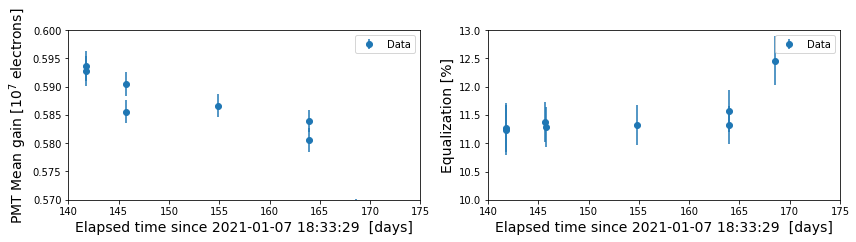

In [7]:
fig, ax = plt.subplots(1,2, figsize=(12, 3.2))

dates = [ datetime.fromtimestamp(t) for t in fitTimeserie[:,0] ]
elapsedTime = [ (t-np.min(fitTimeserie[:,0])) / (3600*24) for t in fitTimeserie[:,0] ] #in days

def decay( x, a, b, c ):
    return b*np.exp( (x-a)*c )

def pol(x,a, b):
    return a + x*b

ax[0].errorbar( x=elapsedTime, y=fitTimeserie[:,1], yerr=fitTimeserie[:,3], fmt='o', label="Data")

ax[0].set_xlabel( "Elapsed time since %s  [days]" % np.min(dates), fontsize=14  )
ax[0].set_ylabel( "PMT Mean gain [$10^7$ electrons]", fontsize=14  )
ax[0].set_xlim((140, 175))
ax[0].set_ylim((0.57, 0.60))

ax[0].legend()

ax[1].errorbar( x=elapsedTime, y=fitTimeserie[:,5], yerr=fitTimeserie[:,6], fmt='o', label="Data")
ax[1].set_xlabel( "Elapsed time since %s  [days]" % np.min(dates), fontsize=14  )
ax[1].set_ylabel( "Equalization [%]", fontsize=14  )
ax[1].set_xlim((140, 175))
ax[1].set_ylim((10, 13))

ax[1].legend()

plt.tight_layout()